In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2021/train.csv
/kaggle/input/tabular-playground-series-apr-2021/test.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
#import datesets
train = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


# EDA

<AxesSubplot:xlabel='Survived', ylabel='count'>

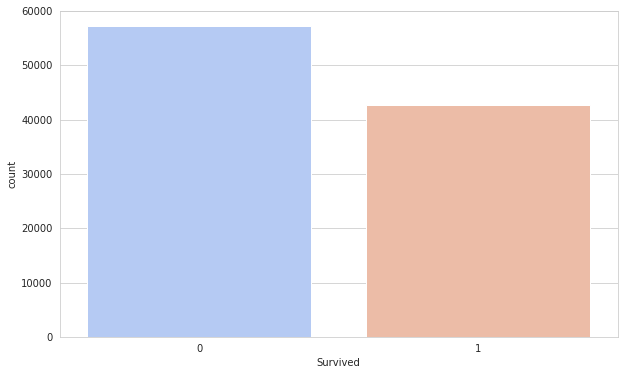

In [6]:
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='coolwarm')

<AxesSubplot:xlabel='Survived', ylabel='count'>

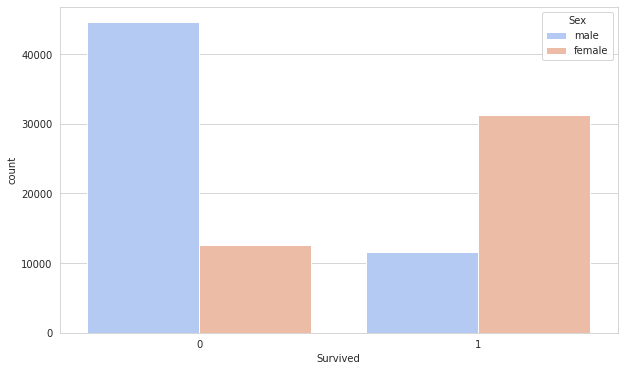

In [7]:
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='coolwarm')

<AxesSubplot:xlabel='Survived', ylabel='count'>

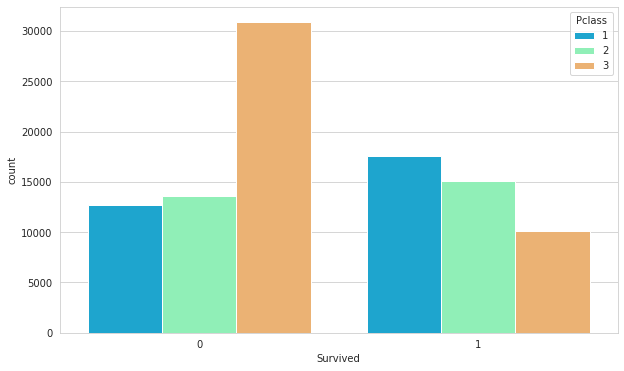

In [8]:
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

<AxesSubplot:>

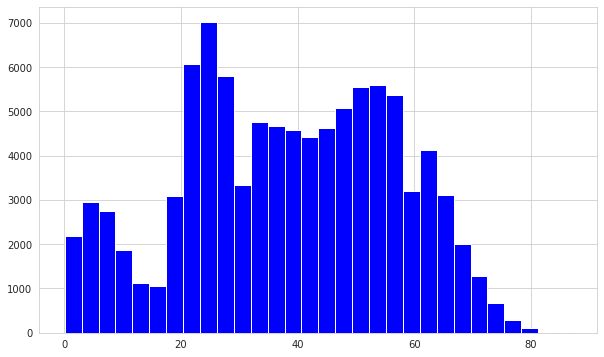

In [9]:
plt.figure(figsize=(10,6))
train['Age'].hist(bins=30,color='blue')

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

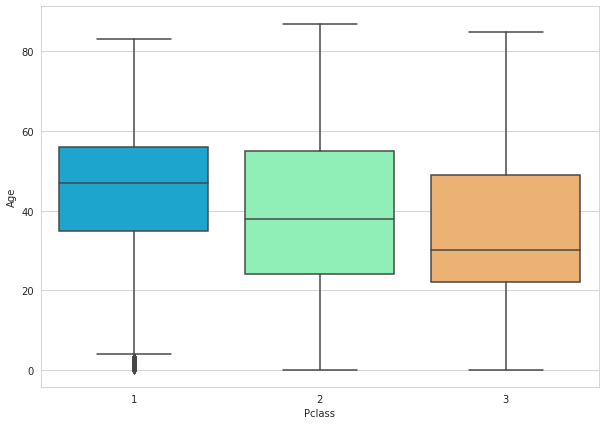

In [10]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='rainbow')

<AxesSubplot:xlabel='Fare', ylabel='Count'>

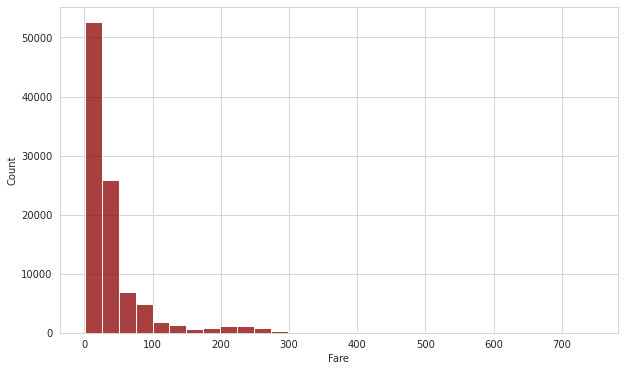

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(train['Fare'].dropna(),color='darkred',bins=30)

**Missing Values**

<AxesSubplot:>

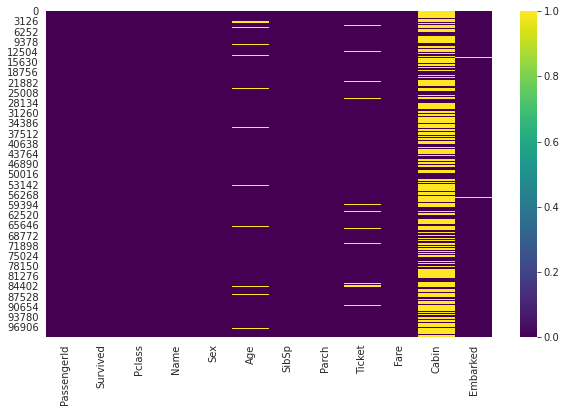

In [12]:
#Missing data check
plt.figure(figsize=(10,6))
sns.heatmap(train.isnull(),cmap='viridis')

test.head()

<AxesSubplot:>

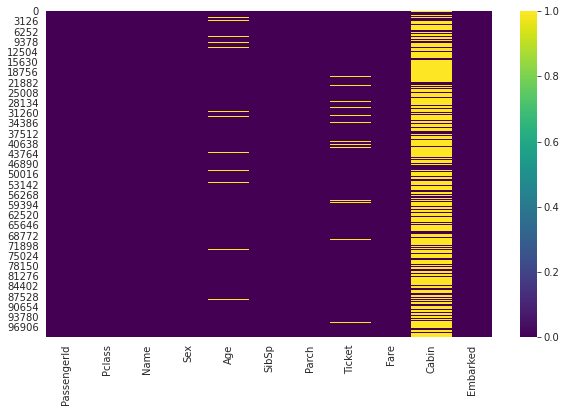

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(test.isnull(),cmap='viridis')

In [14]:
print(f"Average Age of Pclass 1 passengers {train[train['Pclass']==1]['Age'].mean():.2f}")

print(f"Average Age of Pclass 2 passengers {train[train['Pclass']==2]['Age'].mean():.2f}")

print(f"Average Age of Pclass 3 passengers {train[train['Pclass']==3]['Age'].mean():.2f}")


Average Age of Pclass 1 passengers 44.77
Average Age of Pclass 2 passengers 38.63
Average Age of Pclass 3 passengers 33.41


In [15]:
#filling missing values for Age based on the Pclass
def fill_age(c):
    Age = c[0]
    Pclass = c[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 44
        elif Pclass == 2:
            return 38
        else:
            return 33
    else:
        return Age

train['Age'] = train[['Age','Pclass']].apply(fill_age,axis=1)
test['Age'] = train[['Age','Pclass']].apply(fill_age,axis=1)

In [16]:
train.drop(['Ticket','Cabin'],axis=1,inplace=True)
test.drop(['Ticket','Cabin'],axis=1,inplace=True)

<AxesSubplot:>

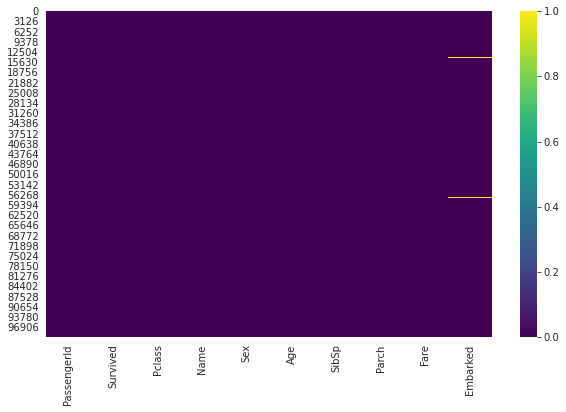

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(train.isnull(),cmap='viridis')

<AxesSubplot:>

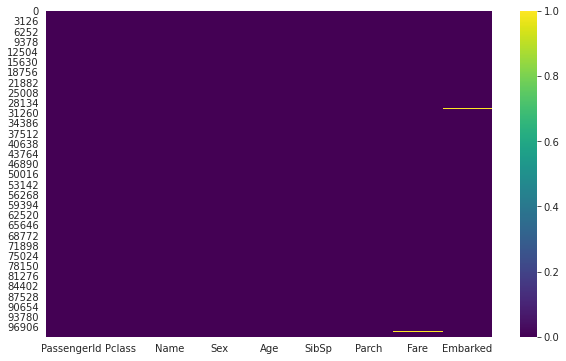

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(test.isnull(),cmap='viridis')

In [19]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train[['Fare']] = imputer.fit_transform(train[['Fare']])
test[['Fare']] = imputer.fit_transform(test[['Fare']])

In [20]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train[['Embarked']] = imputer.fit_transform(train[['Embarked']])
test[['Embarked']] = imputer.fit_transform(test[['Embarked']])

<AxesSubplot:>

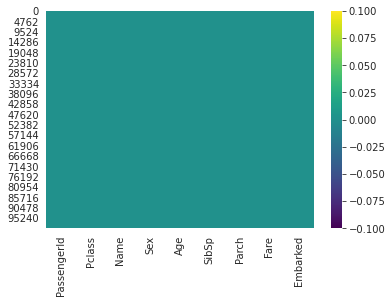

In [21]:
sns.heatmap(test.isnull(),cmap='viridis')

<AxesSubplot:>

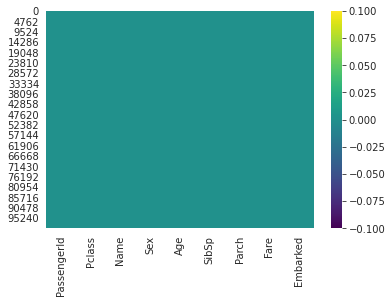

In [22]:
sns.heatmap(test.isnull(),cmap='viridis')

**Encoding Categroical Data**

In [23]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          100000 non-null  float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Fare         100000 non-null  float64
 9   Embarked     100000 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 7.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Pclass       100000 non-null  int64  
 2   Name         100000 n

In [24]:
#train data
S = pd.get_dummies(train['Sex'],drop_first=True)
E = pd.get_dummies(train['Embarked'],drop_first=True)
train = pd.concat([train,S,E],axis=1)
train.drop(['Sex','Embarked','Name'],axis=1,inplace=True)

In [25]:
#test data
S = pd.get_dummies(test['Sex'],drop_first=True)
E = pd.get_dummies(test['Embarked'],drop_first=True)
test = pd.concat([test,S,E],axis=1)
test.drop(['Sex','Embarked','Name'],axis=1,inplace=True)


In [26]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,1,1,44.00,2,0,27.14,1,0,1
1,1,0,3,33.00,0,0,13.35,1,0,1
2,2,0,3,0.33,1,2,71.29,1,0,1
3,3,0,3,19.00,0,0,13.04,1,0,1
4,4,1,3,25.00,0,0,7.76,1,0,1


<AxesSubplot:>

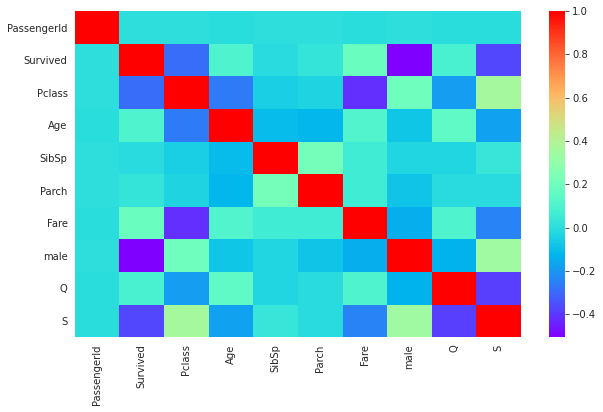

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(),cmap='rainbow')

In [28]:
train.corr()['Survived']

PassengerId    0.001956
Survived       1.000000
Pclass        -0.289723
Age            0.104502
SibSp         -0.007587
Parch          0.023352
Fare           0.187407
male          -0.507260
Q              0.081917
S             -0.366052
Name: Survived, dtype: float64

In [29]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,100000,3,44.00,0,0,63.01,1,0,1
1,100001,3,33.00,0,0,5.81,0,0,1
2,100002,1,0.33,0,0,38.91,0,0,0
3,100003,2,19.00,0,0,12.93,1,0,1
4,100004,1,25.00,0,2,26.89,0,0,0


In [30]:
print(train.shape)
print(test.shape)

(100000, 10)
(100000, 9)


In [31]:
X = train.drop(['PassengerId','Survived'],axis=1)
y = train['Survived']

In [32]:
test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,100000,3,44.00,0,0,63.01,1,0,1
1,100001,3,33.00,0,0,5.81,0,0,1
2,100002,1,0.33,0,0,38.91,0,0,0
3,100003,2,19.00,0,0,12.93,1,0,1
4,100004,1,25.00,0,2,26.89,0,0,0
...,...,...,...,...,...,...,...,...,...
99995,199995,3,62.00,0,0,10.12,0,1,0
99996,199996,1,66.00,1,0,68.31,1,0,1
99997,199997,3,37.00,0,0,10.87,1,0,1
99998,199998,1,51.00,1,2,29.68,0,0,0


**Data Scaling**

In [33]:
sc = StandardScaler()
X = sc.fit_transform(X)
#test data
scaled_test = sc.transform(test.drop('PassengerId',axis=1))

In [34]:
X

array([[-1.32133135,  0.31436039,  1.85761787, ...,  0.88435653,
        -0.23948007,  0.61759643],
       [ 1.06609193, -0.29576703, -0.46105688, ...,  0.88435653,
        -0.23948007,  0.61759643],
       [ 1.06609193, -2.10784549,  0.69828049, ...,  0.88435653,
        -0.23948007,  0.61759643],
       ...,
       [ 1.06609193, -0.07390252, -0.46105688, ...,  0.88435653,
        -0.23948007,  0.61759643],
       [ 1.06609193,  0.7026233 , -0.46105688, ...,  0.88435653,
        -0.23948007,  0.61759643],
       [ 1.06609193,  0.92448782, -0.46105688, ...,  0.88435653,
        -0.23948007,  0.61759643]])

In [35]:
scaled_test

array([[ 1.06609193,  0.31436039, -0.46105688, ...,  0.88435653,
        -0.23948007,  0.61759643],
       [ 1.06609193, -0.29576703, -0.46105688, ..., -1.13076567,
        -0.23948007,  0.61759643],
       [-1.32133135, -2.10784549, -0.46105688, ..., -1.13076567,
        -0.23948007, -1.61918033],
       ...,
       [ 1.06609193, -0.07390252, -0.46105688, ...,  0.88435653,
        -0.23948007,  0.61759643],
       [-1.32133135,  0.7026233 ,  0.69828049, ..., -1.13076567,
        -0.23948007, -1.61918033],
       [-1.32133135,  0.92448782, -0.46105688, ..., -1.13076567,
        -0.23948007, -1.61918033]])

**Splitting the train data for model building**

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=100)

In [37]:
print(X_train.shape)
print(X_test.shape)

(70000, 8)
(30000, 8)


# Logistic Regression Model

In [38]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)

**Evaluation**

In [39]:
print(f'Classification Report\n {classification_report(y_test,predictions)}')
print(f'Confusion Matrix \n {confusion_matrix(y_test,predictions)}')
print(f'\nAccuracy: {accuracy_score(y_test,predictions)*100:.2f}%')


Classification Report
               precision    recall  f1-score   support

           0       0.81      0.77      0.79     17106
           1       0.72      0.76      0.74     12894

    accuracy                           0.77     30000
   macro avg       0.76      0.77      0.76     30000
weighted avg       0.77      0.77      0.77     30000

Confusion Matrix 
 [[13255  3851]
 [ 3114  9780]]

Accuracy: 76.78%


In [40]:
#fitting the whole train data and predciting results for test data
lr.fit(X,y)
lr_prediction = lr.predict(scaled_test)

In [41]:
submission = pd.DataFrame({'PassengerId': test['PassengerId'],'Survived':lr_prediction.flatten()}) 
submission.to_csv('submission.csv',index=False)

# Random Forest Classifier

In [42]:
rf = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [43]:
print(f'Classification Report\n {classification_report(y_test,y_pred)}')
print(f'Confusion Matrix \n {confusion_matrix(y_test,y_pred)}')
print(f'\nAccuracy: {accuracy_score(y_test,y_pred)*100:.2f}%')


Classification Report
               precision    recall  f1-score   support

           0       0.76      0.76      0.76     17106
           1       0.68      0.68      0.68     12894

    accuracy                           0.73     30000
   macro avg       0.72      0.72      0.72     30000
weighted avg       0.73      0.73      0.73     30000

Confusion Matrix 
 [[13044  4062]
 [ 4116  8778]]

Accuracy: 72.74%


In [44]:
#fitting the whole train data and predciting results for test data
rf.fit(X,y)
rf_prediction = rf.predict(scaled_test)

In [45]:
submission = pd.DataFrame({'PassengerId': test['PassengerId'],'Survived':rf_prediction.flatten()}) 
submission.to_csv('submission.csv',index=False)

# ANN

In [46]:
model = Sequential()
model.add(Dense(units=30,activation='relu'))
model.add(Dense(units=15,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [47]:
model.fit(x=X_train,y=y_train,epochs=100,validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
2188/2188 [==============================] - 8s 3ms/step - loss: 0.5278 - val_loss: 0.4893
Epoch 2/100
2188/2188 [==============================] - 5s 2ms/step - loss: 0.4925 - val_loss: 0.4890
Epoch 3/100
2188/2188 [==============================] - 5s 2ms/step - loss: 0.4920 - val_loss: 0.4874
Epoch 4/100
2188/2188 [==============================] - 5s 2ms/step - loss: 0.4935 - val_loss: 0.4872
Epoch 5/100
2188/2188 [==============================] - 5s 2ms/step - loss: 0.4916 - val_loss: 0.4867
Epoch 6/100
2188/2188 [==============================] - 5s 2ms/step - loss: 0.4926 - val_loss: 0.4867
Epoch 7/100
2188/2188 [==============================] - 5s 3ms/step - loss: 0.4917 - val_loss: 0.4858
Epoch 8/100
2188/2188 [==============================] - 5s 2ms/step - loss: 0.4894 - val_loss: 0.4858
Epoch 9/100
2188/2188 [==============================] - 5s 2ms/step - loss: 0.4915 - val_loss: 0.4863
Epoch 10/100
2188/2188 [==============================] - 5s 2ms/step - l

<AxesSubplot:>

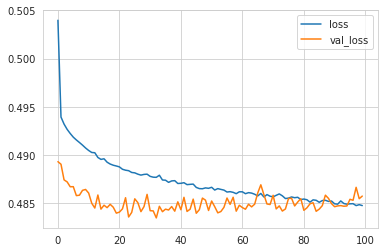

In [48]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [49]:
tf_prediction = model.predict_classes(X_test)

In [50]:
print(f'Classification Report\n {classification_report(y_test,tf_prediction)}')
print(f'Confusion Matrix \n {confusion_matrix(y_test,tf_prediction)}')
print(f'\nAccuracy: {accuracy_score(y_test,tf_prediction)*100:.2f}%')


Classification Report
               precision    recall  f1-score   support

           0       0.81      0.79      0.80     17106
           1       0.73      0.75      0.74     12894

    accuracy                           0.77     30000
   macro avg       0.77      0.77      0.77     30000
weighted avg       0.77      0.77      0.77     30000

Confusion Matrix 
 [[13498  3608]
 [ 3266  9628]]

Accuracy: 77.09%


In [51]:
#Whole train dataset
model.fit(x=X,y=y,epochs=100,verbose=1)

Epoch 1/100
3125/3125 [==============================] - 5s 2ms/step - loss: 0.4849
Epoch 2/100
3125/3125 [==============================] - 5s 2ms/step - loss: 0.4848
Epoch 3/100
3125/3125 [==============================] - 5s 2ms/step - loss: 0.4849
Epoch 4/100
3125/3125 [==============================] - 5s 2ms/step - loss: 0.4848
Epoch 5/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.4847
Epoch 6/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.4847
Epoch 7/100
3125/3125 [==============================] - 5s 2ms/step - loss: 0.4847
Epoch 8/100
3125/3125 [==============================] - 5s 2ms/step - loss: 0.4848
Epoch 9/100
3125/3125 [==============================] - 5s 2ms/step - loss: 0.4846
Epoch 10/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.4843
Epoch 11/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.4845
Epoch 12/100
3125/3125 [==============================] - 5s 2ms/step - lo

In [52]:
tf_prediction = model.predict_classes(scaled_test)

In [53]:
submission = pd.DataFrame({'PassengerId': test['PassengerId'],'Survived':tf_prediction.flatten()}) 
submission.to_csv('submission.csv',index=False)

In [54]:
submission

,PassengerId,Survived
0,100000,0
1,100001,0
2,100002,1
3,100003,0
4,100004,1
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1
